In [1]:
import numpy as np
from scipy.io import loadmat

import os

import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Blues'

import seaborn as sns

import tikzplotlib

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    return onehot.cumsum(axis=time_axis)


policies = [
    'classical ens',
    # 'round robin greedy',
    'greedy',
    'ens jensen greedy'
]
names = [
    'ENS',
    # 'RR-Greedy',
    'One-step',
    'D-ENS'
]
assert len(policies) == len(names)

# postfix = '0.33 corners'
postfix = 'equal radius'
budget = 100

# postfix = 'budget 50'
# budget = 50

n_exps = 20
n_classes = 6
class_names = ['center', 'corner1', 'corner2', 'corner3', 'corner4']
init_size = 1

group_size = n_classes - 1

basepath = os.path.join('../../data/results/square', str(group_size) + ' ' + postfix)


queried_xs = np.ones((len(policies), n_exps, init_size + budget, 2)) * -1
class_counts = -1 * np.ones(
    (len(policies), n_exps, init_size + budget, n_classes), dtype=int
)

for p_ind, policy in enumerate(policies):
    for i in range(n_exps):
        queries = np.loadtxt(
            os.path.join(basepath, policy, f'{policy}__ind__{i + 1}.csv'),
            dtype=int
        ).flatten() - 1
        
        xs = loadmat(
            f'../../data/square/square_nearest_neighbors_{i + 1}.mat'
        )['x']
        
        queried_xs[p_ind, i, :, :] = xs[queries, :]
        
        labels = np.loadtxt(
            os.path.join(basepath, policy, f'{policy}__labels__{i + 1}.csv'), 
            dtype=int
        ).flatten() - 1
        
        class_counts[p_ind, i, :] = labels_to_counts(labels)
        
assert np.all(queried_xs != -1)
assert np.all(class_counts != -1)

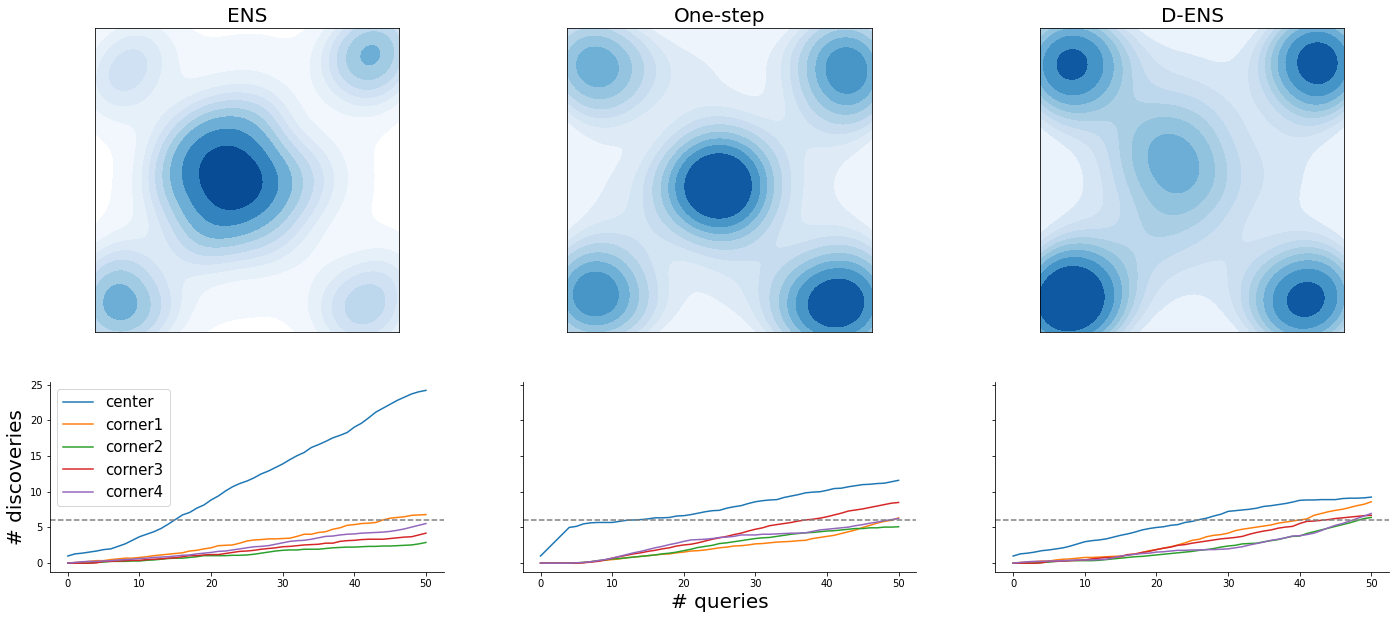

In [3]:
fontsize = 20

cutoff = 6

fig, ax = plt.subplots( 
    2,
    len(policies),
    figsize=(8 * len(policies), 10),
    gridspec_kw={'height_ratios': [1.6, 1]},
    sharey="row"
)

for i, (policy, name) in enumerate(zip(policies, names)):
    sns.kdeplot(
        x=queried_xs[i, :, :, 0].flatten(),
        y=queried_xs[i, :, :, 1].flatten(),
        ax=ax[0, i],
        fill=True,
        cmap="Blues"
    )
    
    ax[0, i].set_xlim(0, 1)
    ax[0, i].set_ylim(0, 1)
    ax[0, i].set_xticklabels([])
    ax[0, i].set_xticks([])
    ax[0, i].set_yticklabels([])
    ax[0, i].set_yticks([])
    ax[0, i].set_aspect('equal', 'box')
    
    for c in range(1, n_classes):
        ax[1, i].plot(
            class_counts[i, :, :, c].mean(axis=0),
            c=f"C{c - 1}",
            label=class_names[c - 1]
        )
    
    ax[0, i].set_title(name, fontsize=fontsize)
    # ax[1, i].set_xlabel("# queries", fontsize=fontsize)
    ax[1, i].spines['right'].set_visible(False)
    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].axhline(cutoff, c="gray", linestyle="--")

ax[1, len(policies) // 2].set_xlabel("# queries", fontsize=fontsize)
ax[1, 0].set_ylabel("# discoveries", fontsize=fontsize)
# ax[1, 0].set_ylim((0, 20))
ax[1, 0].legend(loc="upper left", fontsize=15)

plt.show()
# tikzplotlib.save("square.tex")

In [3]:
from scipy.stats import gaussian_kde

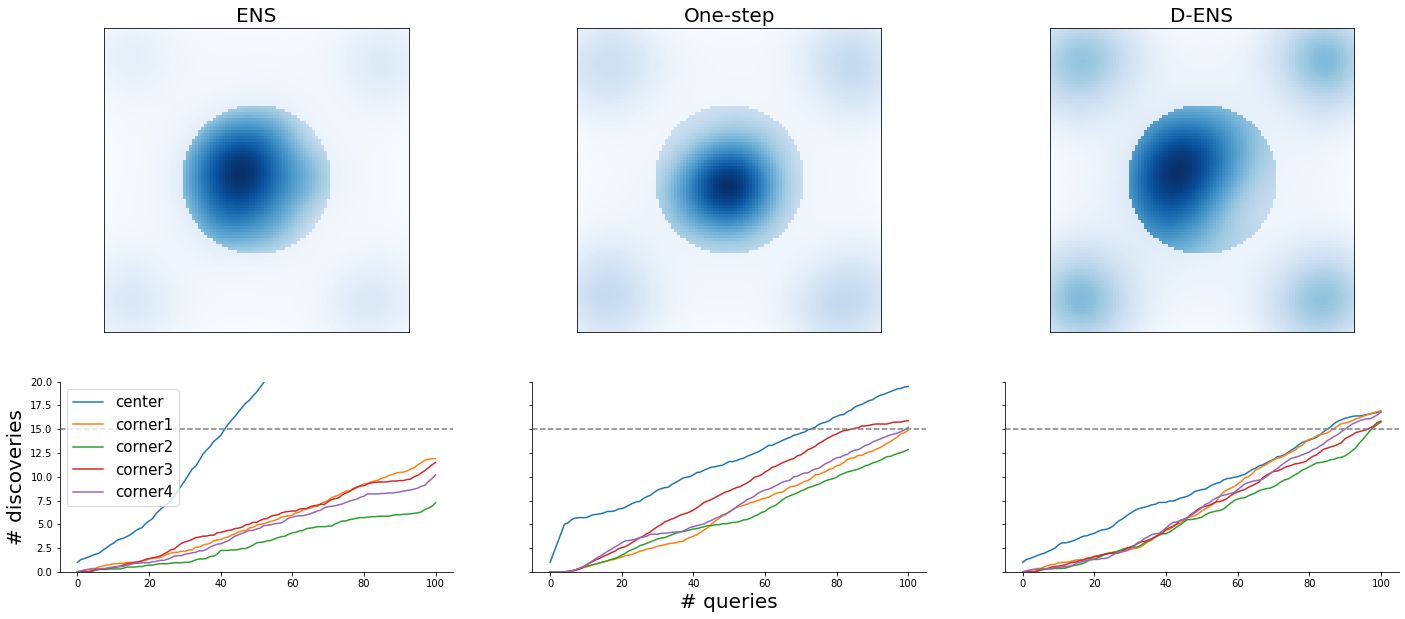

In [6]:
fontsize = 20

cutoff = 15

fig, ax = plt.subplots( 
    2,
    len(policies),
    figsize=(8 * len(policies), 10),
    gridspec_kw={'height_ratios': [1.6, 1]},
    sharey="row"
)

xs = np.linspace(0, 1, 101)
x1, x2 = np.meshgrid(xs, xs, indexing="ij")
xs = np.vstack([x1.flatten(), x2.flatten()]).T


def distance(xs, point):
    return np.sqrt(
        (
            xs - point
        ) ** 2
    )


true_pdfs = np.ones(101 ** 2)
clusters = [
    (np.array([0.5, 0.5]), 0.25, 0.25),
    (np.array([0., 0.]), 0.25, 1),
    (np.array([0., 1.]), 0.25, 1),
    (np.array([1., 0.]), 0.25, 1),
    (np.array([1., 1.]), 0.25, 1),
]
for cluster, radius, rate in clusters:
    distances = np.sqrt(((xs - cluster) ** 2).sum(axis=1))
    mask = distances < radius
    true_pdfs[mask] = rate

for i, (policy, name) in enumerate(zip(policies, names)):
    kde = gaussian_kde(
        [queried_xs[i, :, :, 0].flatten(), queried_xs[i, :, :, 1].flatten()]
    )
    density = (kde(xs.T) / true_pdfs).reshape(101, 101)
    ax[0, i].imshow(density.T, origin="lower", extent=[0, 1, 0, 1])
    
    ax[0, i].set_xlim(0, 1)
    ax[0, i].set_ylim(0, 1)
    ax[0, i].set_xticklabels([])
    ax[0, i].set_xticks([])
    ax[0, i].set_yticklabels([])
    ax[0, i].set_yticks([])
    ax[0, i].set_aspect('equal', 'box')
    
    for c in range(1, n_classes):
        ax[1, i].plot(
            class_counts[i, :, :, c].mean(axis=0),
            c=f"C{c - 1}",
            label=class_names[c - 1]
        )
    
    ax[0, i].set_title(name, fontsize=fontsize)
    # ax[1, i].set_xlabel("# queries", fontsize=fontsize)
    ax[1, i].spines['right'].set_visible(False)
    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].axhline(cutoff, c="gray", linestyle="--")

ax[1, len(policies) // 2].set_xlabel("# queries", fontsize=fontsize)
ax[1, 0].set_ylabel("# discoveries", fontsize=fontsize)
ax[1, 0].set_ylim((0, 20))
ax[1, 0].legend(loc="upper left", fontsize=15)

plt.show()
# tikzplotlib.save("square.tex")

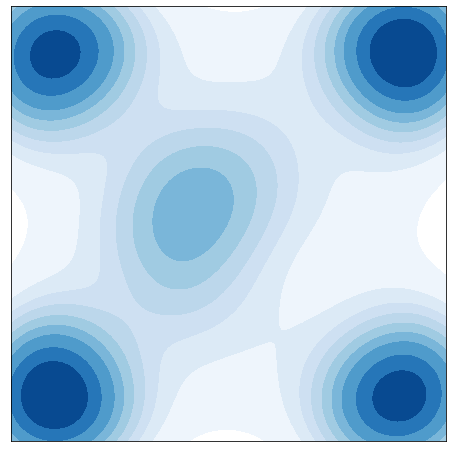

In [10]:
i = 2

fig, ax = plt.subplots(figsize=(8, 8))

sns.kdeplot(
    x=queried_xs[i, :, :, 0].flatten(),
    y=queried_xs[i, :, :, 1].flatten(),
    ax=ax,
    fill=True,
    cmap="Blues"
)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_aspect('equal', 'box')

plt.savefig(f"{names[i]}_heatmap.png")